# Fitting neural network to `Default` dataset (customers defaulting on debt)

In [52]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
from sklearn.linear_model import (LinearRegression, LogisticRegression, Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import (train_test_split, GridSearchCV)
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset
from torchmetrics import (MeanAbsoluteError, R2Score)
from torchinfo import summary
from torchvision.io import read_image
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning import seed_everything
seed_everything(0, workers=True)
torch.use_deterministic_algorithms(True, warn_only=True)
from torchvision.datasets import MNIST, CIFAR100
from torchvision.models import (resnet50, ResNet50_Weights)
from torchvision.transforms import (Resize, Normalize, CenterCrop, ToTensor)
from ISLP.torch import (SimpleDataModule, SimpleModule, ErrorTracker, rec_num_workers)
from ISLP.torch.imdb import (load_lookup, load_tensor, load_sparse, load_sequential)
from sklearn.preprocessing import LabelEncoder

Seed set to 0


## Setting up

Loading data

In [24]:
Default = load_data('Default')
n = Default.shape[0]

Setting up model matrix, MS does this

In [25]:
model = MS(Default.columns.drop('default'), intercept=False)
X = model.fit_transform(Default).to_numpy()
Y = Default['default'].to_numpy()

Splitting data into training and test

In [26]:
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size=0.25, random_state=0)

In [27]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

## Setting up Neural Network

Making a class to structure the model

In [28]:
class DefaultModel(nn.Module):
    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(10, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [29]:
def_model = DefaultModel(X.shape[1])

In [30]:
summary(def_model, input_size=X_train.shape, col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
DefaultModel                             [7500, 3]                 [7500]                    --
├─Flatten: 1-1                           [7500, 3]                 [7500, 3]                 --
├─Sequential: 1-2                        [7500, 3]                 [7500, 1]                 --
│    └─Linear: 2-1                       [7500, 3]                 [7500, 10]                40
│    └─ReLU: 2-2                         [7500, 10]                [7500, 10]                --
│    └─Dropout: 2-3                      [7500, 10]                [7500, 10]                --
│    └─Linear: 2-4                       [7500, 10]                [7500, 1]                 11
│    └─Sigmoid: 2-5                      [7500, 1]                 [7500, 1]                 --
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.38
Input size (MB): 0.09
Forward

Transforming training data into tensors

In [32]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train_encoded.astype(np.float32))
def_train = TensorDataset(X_train_t, Y_train_t)

In [33]:
Y_test_encoded = label_encoder.fit_transform(Y_test)

In [34]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test_encoded.astype(np.float32))
def_test = TensorDataset(X_test_t, Y_test_t)

In [35]:
max_num_workers = rec_num_workers()

Passing into a simpler data loader

In [45]:
def_dm = SimpleDataModule(def_train, def_test, batch_size=32, num_workers=min(4, max_num_workers), validation=def_test)

In [46]:
def_optimizer = RMSprop(def_model.parameters(), lr=0.001)
def_module = SimpleModule.classification(def_model, num_classes=2)
def_logger = CSVLogger('logs', name='Default')

In [47]:
def_trainer = Trainer(deterministic=True, max_epochs=30, logger=def_logger, callbacks=[ErrorTracker()])
def_trainer.fit(def_module, datamodule=def_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DefaultModel     | 51     | train
1 | loss  | CrossEntropyLoss | 0      | train
---------------------------------------------------
51        Trainable params
0         Non-trainable params
51        Total params
0.000     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                               | 0/? [00:00<…

Training: |                                                                                      | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

Validation: |                                                                                    | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=30` reached.


In [48]:
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

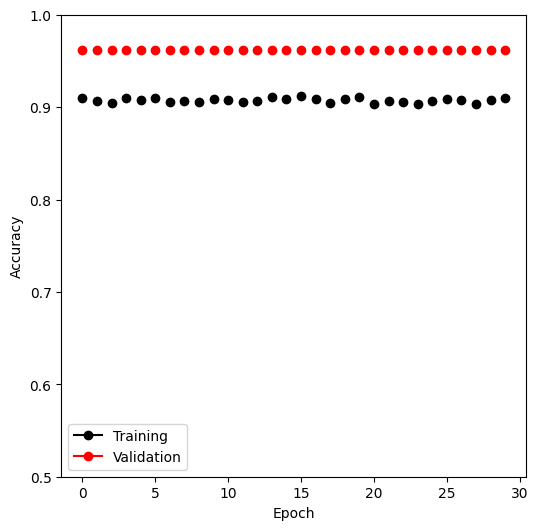

In [50]:
def_results = pd.read_csv(def_logger.experiment.metrics_file_path)
fig, ax = subplots(1, 1, figsize=(6,6))
summary_plot(def_results, ax, col='accuracy', ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int))

In [51]:
def_trainer.test(def_module, datamodule=def_dm)

Testing: |                                                                                       | 0/? [00:00<…

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9616000056266785
        test_loss            751.1084594726562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 751.1084594726562, 'test_accuracy': 0.9616000056266785}]

**96% accuracy** on test data using single layer neural network

## Comparison with Logistic Regression

### Fitting Logistic Regression

In [60]:
scaler = StandardScaler()
model = MS(Default.columns.drop('default'), intercept=False)
d = model.fit_transform(Default)
x = np.asarray(d)
y = Default['default'].values

In [62]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)

In [63]:
logit = LogisticRegression(random_state=0)
logit.fit(x_train, y_train)
pred = logit.predict(x_test)
confusion_table(pred, y_test)

Truth,No,Yes
Predicted,,
No,2397,65
Yes,7,31


In [64]:
np.mean(pred == y_test)

0.9712

Logistic regression actually performs better, with **97% accuracy**